In [33]:
import re
import itertools
import pandas
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

***Read In Data***

In [2]:
file1 = open('chess_fens3.txt')
data = file1.readlines()
file2 = open('chess_results2.txt')
targets = file2.readlines()

In [3]:
print(len(data), len(targets))

22070 20500


***Feature Engineering***

In [4]:
engineered_data = []

for line in data:
    line_features = []
    position = line[:line.index(' ')]
    
    #Split the position into individual squares
    rows = position.split('/')
    expanded_position = []
    for row in rows:
        expanded_row = ''
        for char in row:
            if char.isdigit():
                for i in range(int(char)):
                    expanded_row += ' '
            else:
                expanded_row += char
        expanded_row = [char for char in expanded_row]
        expanded_position += expanded_row
    line_features += expanded_position 
    
    #Count number of each type of piece
    qs = position.count('q')
    Qs = position.count('Q')
    rs = position.count('r')
    Rs = position.count('R')
    pieces = position.count('b')+position.count('n')
    Pieces = position.count('B')+position.count('N')
    pawns = position.count('p')
    Pawns = position.count('P')
    developed_pawns = expanded_position[48:].count('p')
    Developed_Pawns = expanded_position[:16].count('P')
    
    line_features.append(qs)
    line_features.append(Qs)
    line_features.append(rs)
    line_features.append(Rs)
    line_features.append(pieces)
    line_features.append(Pieces)
    line_features.append(pawns)
    line_features.append(Pawns)
    line_features.append(9*(Qs-qs)+5*(Rs-rs)+3*(Pieces-pieces)+(Pawns-pawns)) #material advantage
    line_features.append(developed_pawns)
    line_features.append(Developed_Pawns)
    line_features.append(qs+Qs+rs+Rs+pieces+Pieces+pawns+Pawns)
    
    engineered_data.append(line_features)

engineered_data = np.array([np.array(x) for x in engineered_data])

In [5]:
engineered_data.shape

(22070, 76)

***Process Categorical Data***

In [6]:
les = []
le = LabelEncoder()
le.fit(engineered_data.T[0])
processed_data = le.transform(engineered_data.T[0])
les.append(le)

for col in engineered_data.T[1:64]:
    le = LabelEncoder()
    le.fit(col)
    processed_col = le.transform(col)
    processed_data = np.vstack((processed_data, processed_col))
    les.append(le)

processed_data = np.vstack((processed_data, engineered_data.T[64:]))
processed_data = processed_data.T

In [7]:
print(processed_data.shape, len(les))

(22070, 76) 64


***Oversampling and Train-Test Split***

In [8]:
ys = np.array(targets)
xs = processed_data[:ys.shape[0]]

test_xs = xs[int(0.8*xs.shape[0]):]
test_ys = ys[int(0.8*xs.shape[0]):]
train_xs = xs[:int(0.8*xs.shape[0])]
train_ys = ys[:int(0.8*xs.shape[0])]

ada = ADASYN(random_state = 1729)
train_xs, train_ys = ada.fit_resample(train_xs.astype(np.int), train_ys)

***Train Model***

In [9]:
clf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
clf.fit(train_xs, train_ys)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

***Check Accuracy (best: 67%)***

In [10]:
pred = clf.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred==test_ys if x==True])
print("Out of a total of %d samples, %d were correct" %(total, correct))

Out of a total of 4100 samples, 2787 were correct


***Plot Confusion Matrix (best accuracies: White = 79%, Black = 62%, Draw = 61%)***

Normalized confusion matrix
[[0.78910256 0.08012821 0.13076923]
 [0.19375    0.61607143 0.19017857]
 [0.25352113 0.13661972 0.60985915]]


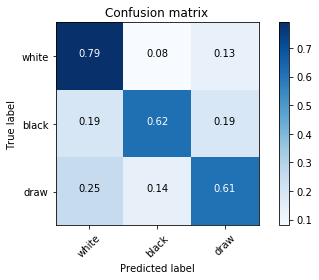

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(test_ys, pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['white', 'black', 'draw'], normalize=True)

In [12]:
print(pred.tolist().count('0\n'), pred.tolist().count('1\n'), pred.tolist().count('2\n'))
print(test_ys.tolist().count('0\n'), test_ys.tolist().count('1\n'), test_ys.tolist().count('2\n'))

1808 1009 1283
1560 1120 1420


In [13]:
clf.feature_importances_

array([0.00603141, 0.00542772, 0.0065483 , 0.00735961, 0.00714185,
       0.01235925, 0.00768965, 0.00664077, 0.00841619, 0.0115239 ,
       0.00825145, 0.00909278, 0.0103613 , 0.01391241, 0.01525374,
       0.01009312, 0.00879501, 0.01128466, 0.0108295 , 0.0118649 ,
       0.01226625, 0.01290523, 0.01127172, 0.01124456, 0.00956919,
       0.01055457, 0.01180404, 0.01377655, 0.01303328, 0.01048996,
       0.01176405, 0.01098481, 0.00886788, 0.01013731, 0.01079554,
       0.01138543, 0.01343609, 0.01131253, 0.01122361, 0.01116411,
       0.00948406, 0.00977109, 0.00985162, 0.00838996, 0.01101705,
       0.01108104, 0.01391174, 0.01170562, 0.00965157, 0.01058042,
       0.00816   , 0.00811388, 0.00905998, 0.01534975, 0.01416788,
       0.01034343, 0.00593191, 0.00493575, 0.00567089, 0.00531339,
       0.0054065 , 0.00820572, 0.00855702, 0.00578116, 0.0073907 ,
       0.00896268, 0.01295498, 0.01287873, 0.01700194, 0.01943318,
       0.03594098, 0.03850349, 0.1600377 , 0.00370105, 0.00528

***Try Gradient Boosters (Best Accuracy: 67%)***

In [14]:
clf2 = GradientBoostingClassifier(n_estimators = 300, max_depth = 2)
clf2.fit(train_xs, train_ys)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Out of a total of 4100 samples, 2740 were correct
Normalized confusion matrix
[[0.73589744 0.10705128 0.15705128]
 [0.14642857 0.64375    0.20982143]
 [0.21267606 0.17394366 0.61338028]]


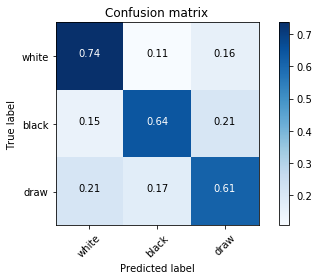

In [15]:
pred2 = clf2.predict(test_xs)
total = test_ys.shape[0]
correct = len([x for x in pred2==test_ys if x==True])
print("Out of a total of %d samples, %d were correct" %(total, correct))

cnf_matrix = confusion_matrix(test_ys, pred2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['white', 'black', 'draw'], normalize=True)

In [16]:
print(pred2.tolist().count('0\n'), pred2.tolist().count('1\n'), pred2.tolist().count('2\n')) #white wins, black wins, draws

1614 1135 1351


In [17]:
clf2.feature_importances_

array([0.00468072, 0.00298032, 0.00688168, 0.00670642, 0.00774919,
       0.02521468, 0.00221635, 0.00778532, 0.00361229, 0.0047707 ,
       0.00325613, 0.00796529, 0.00694873, 0.00822688, 0.01078776,
       0.00161964, 0.00564156, 0.00423159, 0.00457531, 0.00530302,
       0.00580427, 0.00748186, 0.00114883, 0.00719404, 0.00272776,
       0.00750683, 0.00289808, 0.00387243, 0.00253073, 0.00346954,
       0.00972638, 0.00787644, 0.00133102, 0.00218988, 0.00283509,
       0.00261226, 0.00927392, 0.00389634, 0.00705929, 0.00480511,
       0.01022786, 0.00139655, 0.00320027, 0.00490328, 0.00463088,
       0.00420193, 0.00810466, 0.00733767, 0.00297536, 0.00172413,
       0.00250468, 0.00548525, 0.00635261, 0.01108506, 0.01028957,
       0.00305432, 0.00291868, 0.0026835 , 0.00137348, 0.00201921,
       0.00538763, 0.00599107, 0.00685067, 0.00341507, 0.0014024 ,
       0.01171991, 0.00589403, 0.00367676, 0.00384791, 0.01118997,
       0.05384618, 0.03384412, 0.46857148, 0.00700377, 0.01252

In [18]:
def predict_result(fen, classifier = clf):
    global les
    
    line_features = []
    position = fen[:fen.index(' ')]
    
    #Split the position into individual squares
    rows = position.split('/')
    expanded_position = []
    for row in rows:
        expanded_row = ''
        for char in row:
            if char.isdigit():
                for i in range(int(char)):
                    expanded_row += ' '
            else:
                expanded_row += char
        expanded_row = [char for char in expanded_row]
        expanded_position += expanded_row
    line_features += expanded_position
    
    #Count number of each type of piece
    qs = position.count('q')
    Qs = position.count('Q')
    rs = position.count('r')
    Rs = position.count('R')
    pieces = position.count('b')+position.count('n')
    Pieces = position.count('B')+position.count('N')
    pawns = position.count('p')
    Pawns = position.count('P')
    developed_pawns = expanded_position[48:].count('p')
    Developed_Pawns = expanded_position[:16].count('P')
    
    line_features.append(qs)
    line_features.append(Qs)
    line_features.append(rs)
    line_features.append(Rs)
    line_features.append(pieces)
    line_features.append(Pieces)
    line_features.append(pawns)
    line_features.append(Pawns)
    line_features.append(9*(Qs-qs)+5*(Rs-rs)+3*(Pieces-pieces)+(Pawns-pawns)) #material advantage
    line_features.append(developed_pawns)
    line_features.append(Developed_Pawns)
    line_features.append(qs+Qs+rs+Rs+pieces+Pieces+pawns+Pawns)
    
    #Convert to numeric
    transformed = []
    for i in range(64):
        transformed.append(les[i].transform([line_features[i]]))
    transformed += line_features[64:]
    transformed = np.array(transformed)
    transformed = transformed.reshape(1, -1)
    
    #Predict
    pred = classifier.predict(transformed)
    
    #Print prediction
    if pred == '0\n':
        print("White is predicted to win")
    elif pred == '1\n':
        print("Black is predicted to win")
    else:
        print("The predicted result is a draw")
    
    #get "score" (expected points earned by white where win = 1 point and draw = 0.5 points)
    probabilities = classifier.predict_proba(transformed)
    score = probabilities[0][0] + 0.5*probabilities[0][2]
    print("Score: ", score) #a score of > 0.5 favours white. < 0.5 favours black


In [19]:
predict_result("3r1qk1/1pp3pp/p1p2p2/8/7P/2P2P2/P1P2nPK/R3R3 b - - 2 20")

The predicted result is a draw
Score:  0.495


***Cross-Validation and Statistical Tests***

In [ ]:
scores = cross_val_score(clf, xs, ys, cv = KFold(n_splits = 10))

In [46]:
print("scores:", scores)
print("95%% confidence interval: %f (+/- %f)" %(np.mean(scores), np.std(scores)))

scores: [0.66682927 0.67560976 0.6702439  0.64829268 0.71512195 0.66926829
 0.68487805 0.6804878  0.67365854 0.69365854]
95% confidence interval: 0.677805 (+/- 0.016866)


In [74]:
class MaterialClassifier():
    '''classifier based off of material advantage. Assumes material advantage is the index i feature in the data.'''
    def __init__(self, win_boundary, i):
        self.win_boundary = win_boundary
        self.i = i
    
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        return np.array(['0\n' if int(x[self.i]) >= self.win_boundary else '1\n' if int(x[self.i]) <= -self.win_boundary else '2\n' for x in X])
    
    def score(self, X, y):
        pred = self.predict(X)
        total = y.shape[0]
        correct = len([x for x in pred==y if x==True])
        return correct / total
    
    def get_params(self, deep = False):
        return {'win_boundary':self.win_boundary, 'i':self.i}
    
    
material_clf = MaterialClassifier(1, -4)
material_scores = cross_val_score(material_clf, xs, ys, cv = KFold(n_splits = 10))
print("scores:", material_scores)
print("95%% confidence interval: %f (+/- %f)" %(np.mean(material_scores), np.std(material_scores)))
        

scores: [0.62682927 0.64585366 0.6        0.66536585 0.65804878 0.59853659
 0.62146341 0.64829268 0.61365854 0.6595122 ]
95% confidence interval: 0.633756 (+/- 0.023650)


In [76]:
random_scores = [0.33]*10
print("result when compared to random predictions:", ttest_rel(scores, random_scores))
print("result when compared to predictions based on material:", ttest_rel(scores, material_scores))

result when compared to random predictions: Ttest_relResult(statistic=61.86500842335316, pvalue=3.7991994578043955e-13)
result when compared to predictions based on material: Ttest_relResult(statistic=5.226643243160573, pvalue=0.0005443565447409008)
